In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import hdbscan

with zipfile.ZipFile('/content/drive/MyDrive/datas/MID.pkl.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/sample_data')

In [4]:
with open('/content/sample_data/MID.pkl', 'rb') as f:
  mid_df = pickle.load(f)

#### 킬 관련, 첫 오브젝트 관여여부 등 분석에 불필요한 변수 추가 제거

In [5]:
del_list = ['deaths', 'largestcriticalstrike', 'visionwardsboughtingame',
            'largestkillingspree', 'champlevel', 'kills', 'assists', 'goldspent', 
            'firstblood', 'killingsprees', 'firstinhibitor', 'firsttower']

mid_df.drop(columns=del_list, inplace=True)
mid_df.tail(3)

,neutralminionskilledteamjungle,win,neutralminionskilledenemyjungle,damagedealttoobjectives,totaltimecrowdcontroldealt,wardskilled,visionscore,wardsplaced,turretkills,damageselfmitigated,goldearned,neutralminionskilled,damagedealttoturrets,totalheal,totalminionskilled,totaldamagedealttochampions,totalunitshealed,inhibitorkills,totaldamagetaken,timeccingothers,longesttimespentliving,gameduration,championid,position
335819,0.330229,False,0.000000,37.239627,0.889077,0.203218,0.787468,0.152413,0.000000,586.155800,362.540220,0.355631,37.239627,191.583404,4.674005,803.446232,0.025402,0.0,862.480948,0.482642,11.405588,39.366667,7,MID
335820,0.117474,False,0.000000,21.644640,4.787078,0.234949,0.411160,0.117474,0.000000,535.066079,341.703377,0.234949,0.000000,168.399413,5.286344,621.497797,0.029369,0.0,907.988253,0.117474,12.217327,34.050000,91,MID
335821,0.117474,True,0.293686,322.907489,3.230543,0.176211,0.646109,0.146843,0.088106,1695.066079,515.330396,0.616740,170.866373,244.963289,7.048458,992.187959,0.029369,0.0,1052.657856,1.321586,24.405286,34.050000,86,MID


#### Clustering에 사용할 데이터 세분화

In [6]:
mid_df.drop(columns=['position', 'gameduration'], axis=1, inplace=True)
target_df = mid_df[['win', 'championid']]
df_x = mid_df.select_dtypes('float')

In [8]:
print(df_x.shape)
df_x.tail(3)

(335822, 20)


,neutralminionskilledteamjungle,neutralminionskilledenemyjungle,damagedealttoobjectives,totaltimecrowdcontroldealt,wardskilled,visionscore,wardsplaced,turretkills,damageselfmitigated,goldearned,neutralminionskilled,damagedealttoturrets,totalheal,totalminionskilled,totaldamagedealttochampions,totalunitshealed,inhibitorkills,totaldamagetaken,timeccingothers,longesttimespentliving
335819,0.330229,0.000000,37.239627,0.889077,0.203218,0.787468,0.152413,0.000000,586.155800,362.540220,0.355631,37.239627,191.583404,4.674005,803.446232,0.025402,0.0,862.480948,0.482642,11.405588
335820,0.117474,0.000000,21.644640,4.787078,0.234949,0.411160,0.117474,0.000000,535.066079,341.703377,0.234949,0.000000,168.399413,5.286344,621.497797,0.029369,0.0,907.988253,0.117474,12.217327
335821,0.117474,0.293686,322.907489,3.230543,0.176211,0.646109,0.146843,0.088106,1695.066079,515.330396,0.616740,170.866373,244.963289,7.048458,992.187959,0.029369,0.0,1052.657856,1.321586,24.405286


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#### Scaling And KMeans Clustering

In [ ]:
ss_x = StandardScaler().fit_transform(df_x)
mm_x = MinMaxScaler().fit_transform(df_x)
rb_x = RobustScaler().fit_transform(df_x)

In [ ]:
distance = {'ss': [], 'mm': [], 'rb': []}
for idx, data in enumerate([ss_x, mm_x, rb_x]):
  for i in range(2, 11):
    model = KMeans(n_clusters=i)
    model.fit(data)

    distance[list(distance.keys())[idx]].append(model.inertia_)

#### 세가지 케이스에 대한 성능평가 Visualization 1
- KMeans의 inertia_를 통한 군집간 응집도 계산

In [ ]:
k_df = pd.DataFrame(distance)
k_df.index = range(2, 11)

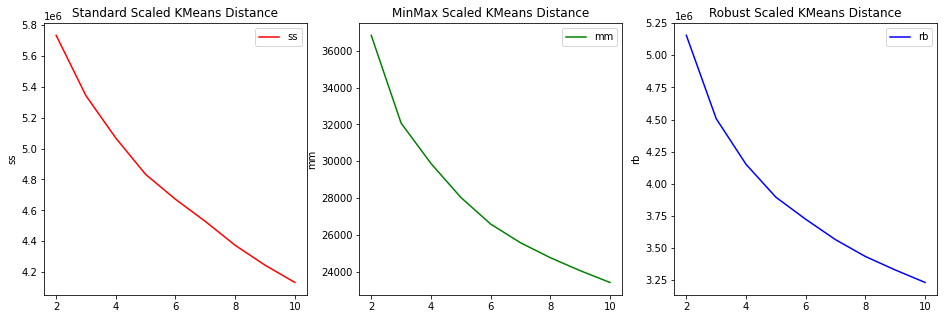

In [ ]:
plt.figure(figsize=(16, 5))

plt.subplot(131)
sns.lineplot(data=k_df, x=k_df.index, y='ss', label='ss', color='r')
plt.title("Standard Scaled KMeans Distance")

plt.subplot(132)
sns.lineplot(data=k_df, x=k_df.index, y='mm', label='mm', color='g')
plt.title("MinMax Scaled KMeans Distance")

plt.subplot(133)
sns.lineplot(data=k_df, x=k_df.index, y='rb', label='rb', color='b')
plt.title("Robust Scaled KMeans Distance")

plt.show()

#### 세가지 케이스에 대한 성능평가 Visualization 2
- 실루엣 계수를 사용한 성능평가

In [ ]:
sil_scores = {"ss": [], "mm": [], "rb": []}
for idx, data in enumerate([ss_x, mm_x, rb_x]):
  for i in range(2, 11):
    print(i)
    model=KMeans(n_clusters=i, random_state=13)
    model.fit(data)

    score = silhouette_score(data, model.labels_)
    sil_scores[list(sil_scores.keys())[idx]].append(score)
  print(f'end {list(sil_scores.keys())[idx]}')

2
3
4
5
6
7
8
9
10
end ss
2
3
4
5
6
7
8
9
10
end mm
2
3
4
5
6
7
8
9
10
end rb


In [ ]:
sil_df = pd.DataFrame(sil_scores)
sil_df.index = range(2, 11)

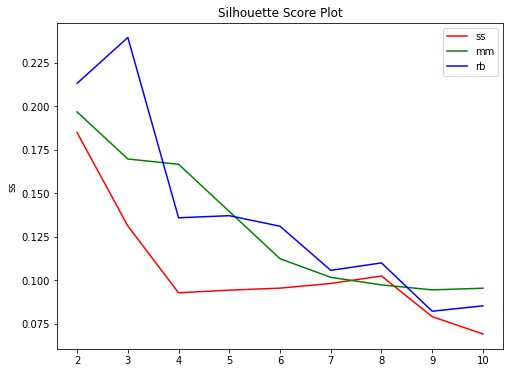

In [ ]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=sil_df, x=sil_df.index, y='ss', label='ss', color='r')
sns.lineplot(data=sil_df, x=sil_df.index, y='mm', label='mm', color='g')
sns.lineplot(data=sil_df, x=sil_df.index, y='rb', label='rb', color='b')
plt.title("Silhouette Score Plot")

plt.show()

#### 시각화를 통한 Clustering 성능평가
- PCA를 사용해 2차원으로 차원축소
- KMeans.n_clusters = 10일 때의 clustering 결과에 대한 시각화

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


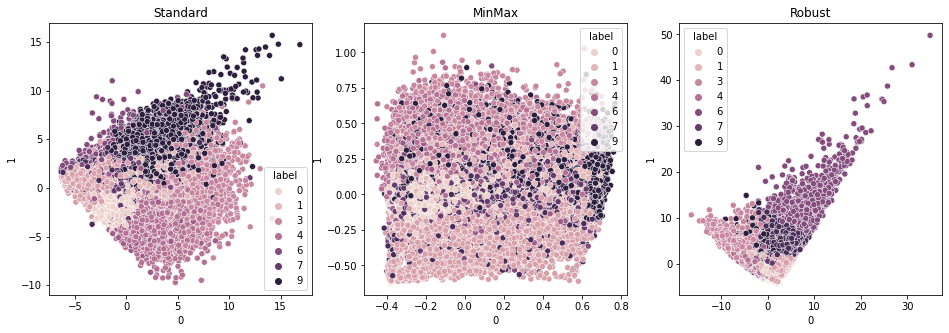

In [ ]:
plt.figure(figsize=(16, 5))

titles = ["Standard", "MinMax", "Robust"]
scaled_datas = [ss_x, mm_x, rb_x]
for idx, data in enumerate(scaled_datas):
  pca = PCA(n_components=2)
  result = pd.DataFrame(pca.fit_transform(data))
  result['label'] = model.labels_

  plt.subplot(1, 3, idx+1)
  sns.scatterplot(data=result, x=0, y=1, hue='label')
  plt.title(titles[idx])

plt.show()